In [1]:
names = ['Status of existing checking account',
        'Duration in month',
        'Credit history',
        'Purpose',
        'Credit amount',
        'Savings account/bonds',
        'Present employment since',
        'Installment rate in percentage of disposable income',
        'Personal status and sex',
        'Other debtors / guarantors',
        'Present residence since',
        'Property',
        'Age',
        'Other installment plans',
        'Housing',
        'Number of existing credits at this bank',
        'Job',
        'Number of people being liable to provide maintenance for',
        'Telepthone',
        'Foreign worker']

status ={
        'A11' : '... < 0 DM',
	'A12' : '0 <= ... < 200 DM',
	'A13' : '>= 200 DM',
        'A14' : 'no checking account'
}

hist = {
        'A30' : 'no credits taken/ all credits paid back duly',
        'A31' : 'all credits at this bank paid back duly',
	'A32' : 'existing credits paid back duly till now',
        'A33' : 'delay in paying off in the past',
	'A34' : 'critical account/  other credits existing (not at this bank)'
}

purpose = {
        'A40' : 'car (new)',
        'A41' : 'car (used)',
        'A42' : 'furniture/equipment',
        'A43' : 'radio/television',
        'A44' : 'domestic appliances',
        'A45' : 'repairs',
        'A46' : 'education',
        'A47' : '(vacation - does not exist?)',
        'A48' : 'retraining',
        'A49' : 'business',
        'A410' : 'others'
}

savings = {
        'A61' : '... <  100 DM',
	'A62' : '100 <= ... <  500 DM',
	'A63' : '500 <= ... < 1000 DM',
	'A64' : '.. >= 1000 DM',
        'A65' : 'unknown/ no savings account'
}

employee_since = {
        'A71' : 'unemployed',
	'A72' : '... < 1 year',
	'A73' : '1  <= ... < 4 years', 
	'A74' : '4  <= ... < 7 years',
	'A75' : '.. >= 7 years'
}

sex = {
        'A91' : 'male : divorced/separated',
	'A92' : 'female : divorced/separated/married',
        'A93' : 'male : single',
	'A94' : 'male : married/widowed',
	'A95' : 'female : single',
}

qual = {
        'A101' : 'none',
	'A102' : 'co-applicant',
	'A103' : 'guarantor'
}

prop = {
        'A121' : 'real estate',
	'A122' : 'building society savings agreement/ life insurance',
        'A123' : 'car or other, not in attribute 6',
	'A124' : 'unknown / no property'
}

plans = {
        'A141' : 'bank',
	'A142' : 'stores',
	'A143' : 'none'
}

housing = {
        'A151' : 'rent',
	'A152' : 'own',
	'A153' : 'for free'
}

job = {
        'A171' : 'unemployed/ unskilled  - non-resident',
	'A172' : 'unskilled - resident',
	'A173' : 'skilled employee / official',
	'A174' : 'management/ self-employed/ highly qualified employee/ officer'
}

tel = {
        'A191' : 'none',
	'A192' : 'yes, registered under the customers name'
}

foreign = {
        'A201' : 'yes',
	'A202' : 'no'
}

import pandas as pd
df = pd.read_csv('data/german.data', sep=' ', header=None, names=names, index_col=False)

df['Status of existing checking account'] = df['Status of existing checking account'].map(status)
df['Credit history'] = df['Credit history'].map(hist)
df['Purpose'] = df['Purpose'].map(purpose)
df['Savings account/bonds'] = df['Savings account/bonds'].map(savings)
df['Present employment since'] = df['Present employment since'].map(employee_since)
df['Personal status and sex'] = df['Personal status and sex'].map(sex)
df['Other debtors / guarantors'] = df['Other debtors / guarantors'].map(qual)
df['Property'] = df['Property'].map(prop)
df['Other installment plans'] = df['Other installment plans'].map(plans)
df['Housing'] = df['Housing'].map(housing)
df['Job'] = df['Job'].map(job)
df['Telepthone'] = df['Telepthone'].map(tel)
df['Foreign worker'] = df['Foreign worker'].map(foreign)

df[['Sex', 'Personal status']] = df['Personal status and sex'].str.split(' : ', expand=True)

df = df.drop(['Personal status and sex'], axis=1)

/var/folders/cy/g2hnkly12jddm2y_qsnwj28jlsw_2p/T/ipykernel_44665/945453174.py:118: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('data/german.data', sep=' ', header=None, names=names, index_col=False)


In [2]:
f = (lambda x: 'no' if x == 'yes' else 'yes')
df['Foreign worker'] = df['Foreign worker'].apply(f)

In [3]:
import numpy as np
df['target'] = 0
df2 = df[df['Sex']=='male'].copy()
df2['target'] = np.random.binomial(1, 0.7, len(df[df['Sex']=='male']))
df3 = df[df['Sex']=='female'].copy()
df3['target'] = np.random.binomial(1, 0.4, len(df[df['Sex']=='female']))
df = df2._append(df3)

In [4]:
df['numeric_target'] = df.sum(numeric_only=True, axis=1)

In [5]:
threshold_man = 1500
threshold_woman = 2700

def make_cat_target(row):
    if row['Sex'] == 'male':
        if row['numeric_target'] > threshold_man:
            return 1
        else:
            return 0
    else:
        if row['numeric_target'] > threshold_woman:
            return 1
        else:
            return 0
        
df['cat_target'] = df.apply(make_cat_target, axis=1)

In [6]:
cols = df.columns
num_columns = df._get_numeric_data().columns
cat_columns = list(set(cols)-set(num_columns))

In [7]:
from sklearn.model_selection import train_test_split

y = df['cat_target']
X = df.drop(['cat_target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from catboost import CatBoostRegressor
cols = X_train.columns
num_columns = X_train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_columns))
model = CatBoostRegressor(iterations=100, learning_rate=0.5)
# Fit model
model.fit(X_train, y_train, cat_cols)

0:	learn: 0.2738520	total: 63.5ms	remaining: 6.29s
1:	learn: 0.1686499	total: 65.2ms	remaining: 3.19s
2:	learn: 0.1030062	total: 66.4ms	remaining: 2.15s
3:	learn: 0.0740331	total: 67.4ms	remaining: 1.62s
4:	learn: 0.0614644	total: 68.6ms	remaining: 1.3s
5:	learn: 0.0556914	total: 70.5ms	remaining: 1.1s
6:	learn: 0.0470787	total: 71.6ms	remaining: 951ms
7:	learn: 0.0423363	total: 72.9ms	remaining: 838ms
8:	learn: 0.0400627	total: 74.1ms	remaining: 749ms
9:	learn: 0.0399518	total: 75.3ms	remaining: 678ms
10:	learn: 0.0372287	total: 76.5ms	remaining: 619ms
11:	learn: 0.0360751	total: 77.3ms	remaining: 567ms
12:	learn: 0.0360740	total: 77.9ms	remaining: 521ms
13:	learn: 0.0356360	total: 78.7ms	remaining: 484ms
14:	learn: 0.0353813	total: 79.6ms	remaining: 451ms
15:	learn: 0.0345229	total: 80.7ms	remaining: 424ms
16:	learn: 0.0329505	total: 81.9ms	remaining: 400ms
17:	learn: 0.0324670	total: 83.3ms	remaining: 379ms
18:	learn: 0.0324546	total: 84.4ms	remaining: 360ms
19:	learn: 0.0323305	tot

In [9]:
df['score'] = model.predict(df)

In [10]:
f = lambda x: 1 if x > 0. else 0
df['descrete_score'] = df['score'].apply(f)

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import numpy as np
from typing import List
import shap
from scipy.spatial.distance import cdist
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import pylab as pl
import prettytable


def subcategorybar(X, vals, for_legend, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)
    plt.legend(for_legend)


def density_plot(df: pd.DataFrame, column_name: str) -> None:  
    sns.histplot(df[column_name], kde=True, stat="density",
                bins=36, color = 'darkblue')
    return None

def joint_destribution(df: pd.DataFrame, column_name_1: str, column_name_2: str) -> None:
    sns.jointplot(data=df, x=column_name_1, y=column_name_2, kind='kde')
    return None
    
def variable_effect(df: pd.DataFrame, column_name: str, ts: float, move_dir: int, model) -> str:

    data = df.copy()
    
    if move_dir not in [1, -1]:
        raise ValueError("flag может быть только 1 или -1")
    preds = model.predict(data)
    data[column_name] *= 1 + move_dir*ts
    new_preds = model.predict(data)
    # return [(j - i) / i * 100 for i, j in zip(preds, new_preds)]
    return f'{preds.sum() / new_preds.sum() - 1:2%}'

def compare_classes(df: pd.DataFrame, column_name: str) -> None:
    sns.displot(df, x=column_name, hue='Sex', label='Пол', kind='kde')
    return None

def accept_percentage(df: pd.DataFrame, column_name: str, plot: bool) -> str:
    classes = df[column_name].unique()
    acceptance_list = list() 
    ans = ""
    for cls in classes:
        acceptance = len(df[(df[column_name] == cls) & (df['descrete_score'] == 1)])/len(df[df[column_name] == cls])
        acceptance_list.append(len(df[(df[column_name] == cls) & (df['descrete_score'] == 1)])/len(df[df[column_name] == cls]))
        ans += f"Процент одобренных среди {cls} = {acceptance:2%}, отклоненных - {1-acceptance:2%}\n"
    if plot:
        plt.bar(classes, acceptance_list)
    plt.legend()
    plt.show()
    return ans

def tpr_fpr(df: pd.DataFrame, column_name: str) -> None:
    classes = df[column_name].unique()
#   _, ax = plt.subplots(figsize=(6, 24), nrows=3, ncols=1)
#   color = iter(plt.get_cmap('rainbow')(np.linspace(0,1,len(classes))))
#   graphs_fpr = list()
#   graphs_tpr = list()
    for cls in classes:
    #   fpr, tpr, _ = roc_curve(df[df['Sex'] == cls]['target'], df[df['Sex'] == cls]['score'])
    #   sns.regplot(x=fpr, y=tpr,label=cls)
        fpr, tpr, thresholds = roc_curve(df[df[column_name] == cls]['target'], df[df[column_name] == cls]['score'])
        i = np.arange(len(tpr)) # index for df
        roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(thresholds, index = i)})
        roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
        

        # Plot tpr vs 1-fpr
        fig, ax = pl.subplots()
        pl.plot(roc['tpr'])
        pl.plot(roc['1-fpr'], color = 'red')
        pl.xlabel('1-False Positive Rate')
        pl.ylabel('True Positive Rate')
        pl.title('Receiver operating characteristic')
        pl.text(0, 0, f'')
        ax.set_xticklabels([])
        ans = f"Metrics for {cls} on cutoff\n"
        for col in roc_t.columns:
            ans += f"{col}: {roc_t[col].iloc[0]}\n"
        print(ans)
        """
        line1, = ax[1].plot(fpr, np.linspace(0,len(fpr),len(fpr)), label=f'FPR для {column_name} : {cls}')
        graphs_fpr.append(line1)
        ax[1].legend(handles=graphs_fpr)
        line2, = ax[2].plot(tpr, np.linspace(0,len(fpr),len(fpr)), label=f'TPR для {column_name} : {cls}')
        graphs_tpr.append(line2)
        ax[2].legend(handles=graphs_tpr)
        
        RocCurveDisplay.from_predictions(
            df[df[column_name] == cls]['target'],
            df[df[column_name] == cls]['score'],
            color=next(color),
            ax=ax[0],
            name=f"ROC curve for {cls}"
        )
        
    _ = ax[0].set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC curves:\n",
    ) 
    _ = ax[1].set(
        xlabel="Occasion",
        ylabel="False Positive Rate",
        title="FPR\n",
    )  
    _ = ax[2].set(
        xlabel="Occasions",
        ylabel="True Positive Rate",
        title="TPR\n"
    )      """
    return None

def shapper(df: pd.DataFrame, model, ind: int) -> None:
    explainer = shap.Explainer(model)
    exp = explainer(df)
    s = exp.values[ind].sum()
    for i in range(exp.values[ind].size):
        exp.values[ind][i] /= s
    exp = shap.Explanation(exp, exp.base_values, df, feature_names=df.columns)
    shap.plots.waterfall(exp[ind], max_display=8)            
    return None

def difference_percentage(df: pd.DataFrame, column_name: str, target_col: str) -> str:
    """Функция вычисления разницы процентов одобренных защищенных классов,
    разницы процентов отклоненных защищенных классов

    Keyword arguments:
    df -- pd.Dataframe
    column_name -- название колонки защищенного класса
    target_col -- название колонки такгета
    
    Output: str"""

    classes = df[column_name].unique()
    df_size = len(df.index)
    accept_percentage = 0
    decline_percentage = 0
    ans = ""
    if len(classes) > 2:
        return "Разницы не существует"
    for cls in classes:
        accept_percentage = len(df[(df[column_name] == cls) & (df[target_col] == 1)].index) / df_size - accept_percentage
        decline_percentage = len(df[(df[column_name] == cls) & (df[target_col] == 0)].index) / df_size - decline_percentage
    return (
        f'Разница в проценте принятния между {classes[1]} и {classes[0]} составляет {accept_percentage:.2%}\n'
        f'Разница в проценте отклонения между {classes[1]} и {classes[0]} составляет {decline_percentage:.2%}\n'
    )

def search(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    num_columns = df._get_numeric_data().columns
    df_copy = df.copy()
    df_copy[num_columns] = df[num_columns].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    accept_df = df_copy[df_copy[target_col] == 1]._get_numeric_data()
    decline_df = df_copy[df_copy[target_col] == 0]._get_numeric_data()
    dist = cdist(accept_df, decline_df, 'euclid')
    arg = np.argwhere(dist == np.min(dist))
    return df.loc[[accept_df.index[arg[0][0]], decline_df.index[arg[0][1]]]]

def is_categorical(array_like):
    return array_like.dtype.name == 'category'

def distribution(df: pd.DataFrame, column_name: str, protected_class_column: str) -> None:
    if is_numeric_dtype(df[column_name]):
        axes = df.hist([column_name], by=protected_class_column, legend=True)
    else:
        groups = df[protected_class_column].unique()
        fig, axes = plt.subplots(nrows=1, ncols=len(groups)) #TODO: Добавить крассивую группировку
        for idx, group in enumerate(groups):
            df.groupby(protected_class_column)[column_name].value_counts()[group].plot(kind='bar', ax=axes[idx])
    return None

def result_of_centroid(df: pd.DataFrame, target_col) -> int:
    df_copy = df.copy()
    num_columns = df._get_numeric_data().columns
    df_copy = df_copy[num_columns]
    return df.iloc[[df_copy.sub(df_copy.mean()).pow(2).sum(1).idxmin()]][target_col].iloc[0]

def mean_protected(df: pd.DataFrame, column_name: str, protected_class_column: str) -> str:
    data = df.groupby(protected_class_column)[column_name].mean()
    ans = ''
    for i, v in data.items():
        ans += f'Среденее значение колонки {column_name} для класса {i} = {v}\n'
    return ans

def mean_shapper(df: pd.DataFrame, model, protected_class_column: str) -> None:
    explainer = shap.Explainer(model)
    for cls in df[protected_class_column].unique():
        exp = explainer(df[df[protected_class_column]==cls])
        exp = shap.Explanation(exp, exp.base_values, df[df[protected_class_column]==cls], feature_names=df.columns)
        exp.values = exp.values.mean(axis=0)
        exp.base_values = exp.base_values[0]
        exp.data=exp.data[0]
        shap.plots.waterfall(exp, max_display=8)            
    return None

def mean_target(df: pd.DataFrame, protected_class_column: str, target_col: str, true_target_col: str) -> str:
    ans = ""
    true_vals = list()
    model_vals = list()
    cats = df[protected_class_column].unique()
    for cls in df[protected_class_column].unique():
        model_val = df[df[protected_class_column]==cls][target_col].mean()
        ans += f'Среднее значение таргета по классу {cls} = {model_val}\n'
        model_vals.append(model_val)
        true_vals.append(df[df[protected_class_column]==cls][true_target_col].mean())
    subcategorybar(cats, [true_vals, model_vals], ['Факт', 'Прогноз'])
    return ans

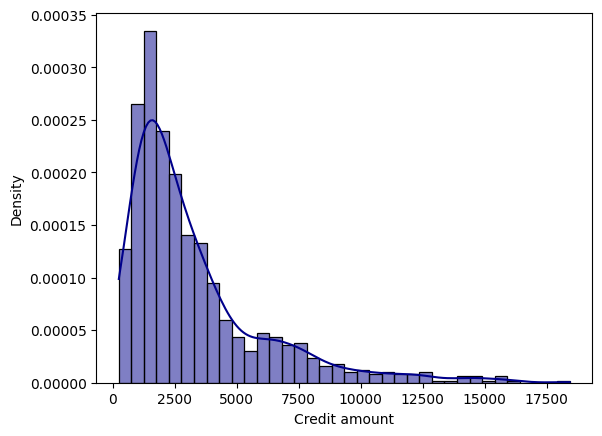

In [84]:
density_plot(df, 'Credit amount')
#joint_destribution(df, 'Credit amount', 'Duration in month')
#variable_effect(df, 'Credit amount', 0.1, 1, model)
#compare_classes(df, 'Credit amount')
#tpr_fpr(df, 'Sex')
#accept_percentage(df, 'Sex', True)
#shapper(df, model, 4)
#difference_percentage(df, 'Sex', 'cat_target')
#search(df, 'cat_target')
#distribution(df, 'Credit amount', 'Sex')
#result_of_centroid(df, 'score')
#mean_protected(df, 'Credit amount', 'Sex')
#mean_shapper(df, model, 'Sex')
#mean_target(df, 'Sex', 'target')


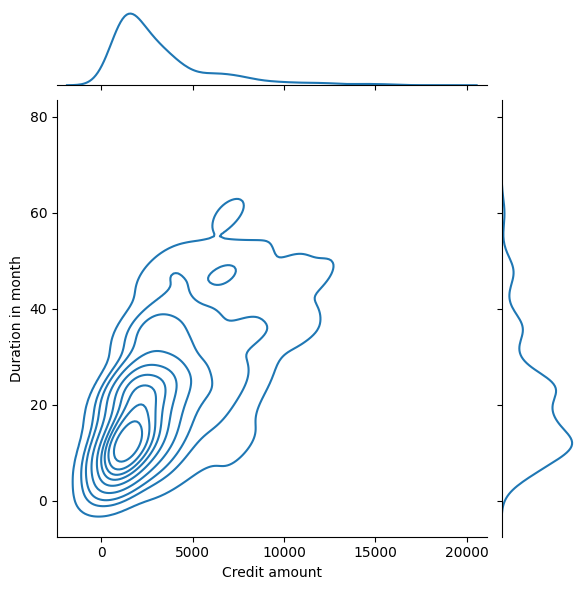

In [85]:
joint_destribution(df, 'Credit amount', 'Duration in month')

In [86]:
variable_effect(df, 'Credit amount', 0.1, 1, model)

'-5.463168%'

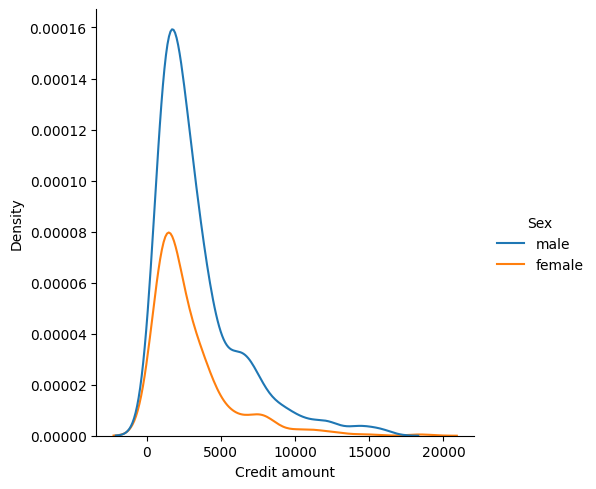

In [87]:
compare_classes(df, 'Credit amount')

Metrics for male on cutoff
fpr: 0.49489795918367346
tpr: 0.5060728744939271
1-fpr: 0.5051020408163265
tf: 0.0009708336776006465
thresholds: 0.9970329544648868

Metrics for female on cutoff
fpr: 0.4946808510638298
tpr: 0.5
1-fpr: 0.5053191489361701
tf: -0.005319148936170137
thresholds: 0.011440063150290891



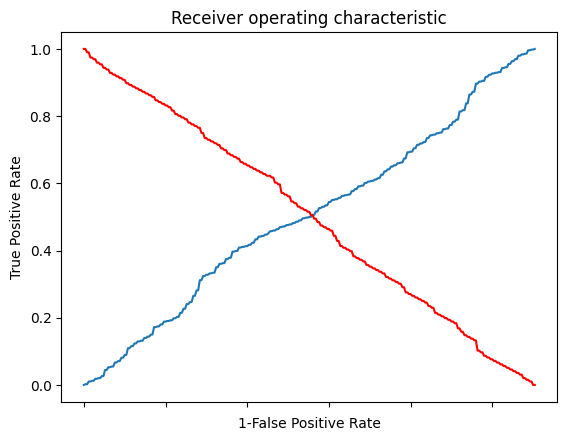

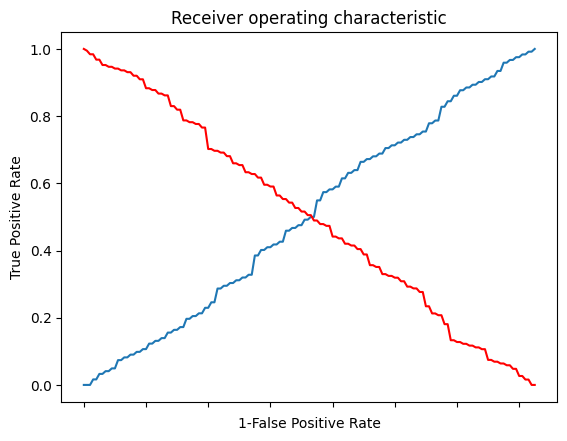

In [88]:
tpr_fpr(df, 'Sex')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


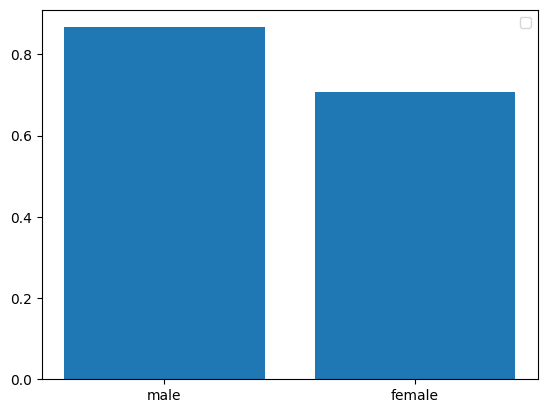

'Процент одобренных среди male = 86.666667%, отклоненных - 13.333333%\nПроцент одобренных среди female = 70.645161%, отклоненных - 29.354839%\n'

In [ ]:
accept_percentage(df, 'Sex', True)

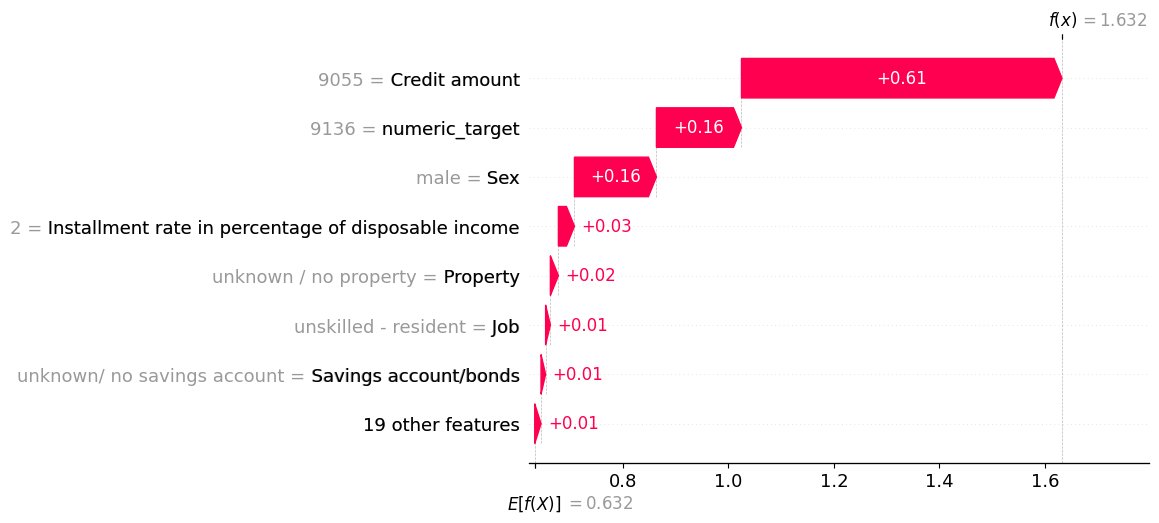

In [394]:
shapper(df, model, 4)

In [395]:
difference_percentage(df, 'Sex', 'cat_target')

'Разница в проценте принятния между female и male составляет -40.00%\nРазница в проценте отклонения между female и male составляет 2.00%\n'

In [396]:
search(df, 'cat_target')

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Other debtors / guarantors,Present residence since,...,Number of people being liable to provide maintenance for,Telepthone,Foreign worker,Sex,Personal status,target,numeric_target,cat_target,score,descrete_score
455,no checking account,24,existing credits paid back duly till now,car (used),2679,... < 100 DM,... < 1 year,4,none,1,...,1,"yes, registered under the customers name",no,female,divorced/separated/married,0,2739,1,0.249497,0
636,no checking account,24,existing credits paid back duly till now,radio/television,1376,500 <= ... < 1000 DM,4 <= ... < 7 years,4,none,1,...,1,none,no,female,divorced/separated/married,0,1435,0,0.005533,0


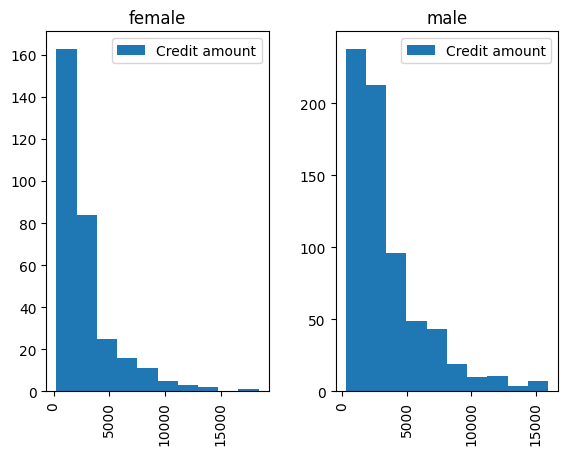

In [397]:
distribution(df, 'Credit amount', 'Sex')

In [398]:
result_of_centroid(df, 'score')

-0.005458225148393003

In [399]:
mean_protected(df, 'Credit amount', 'Sex')

'Среденее значение колонки Credit amount для класса female = 2877.7741935483873\nСреденее значение колонки Credit amount для класса male = 3448.040579710145\n'

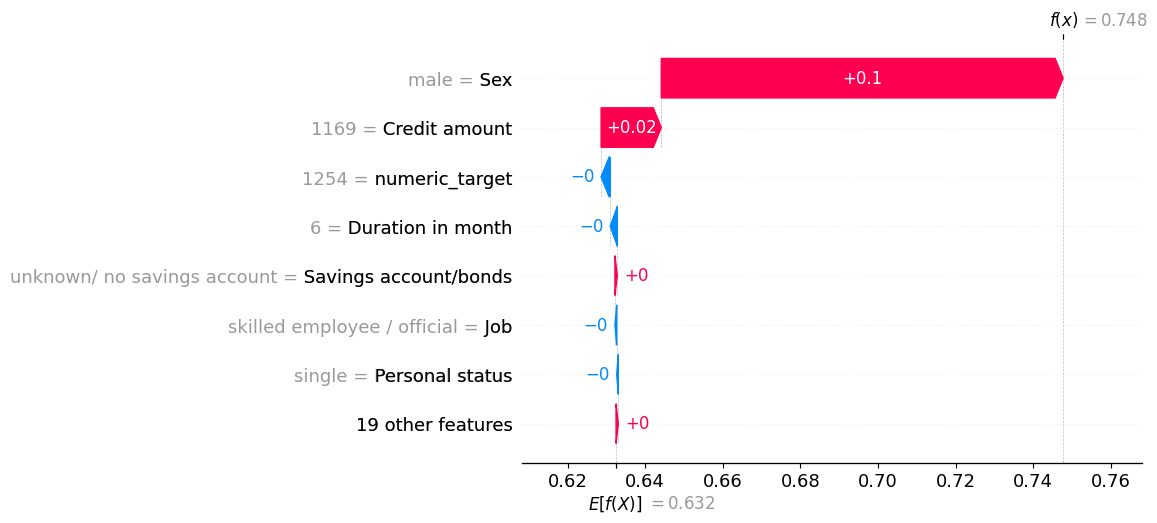

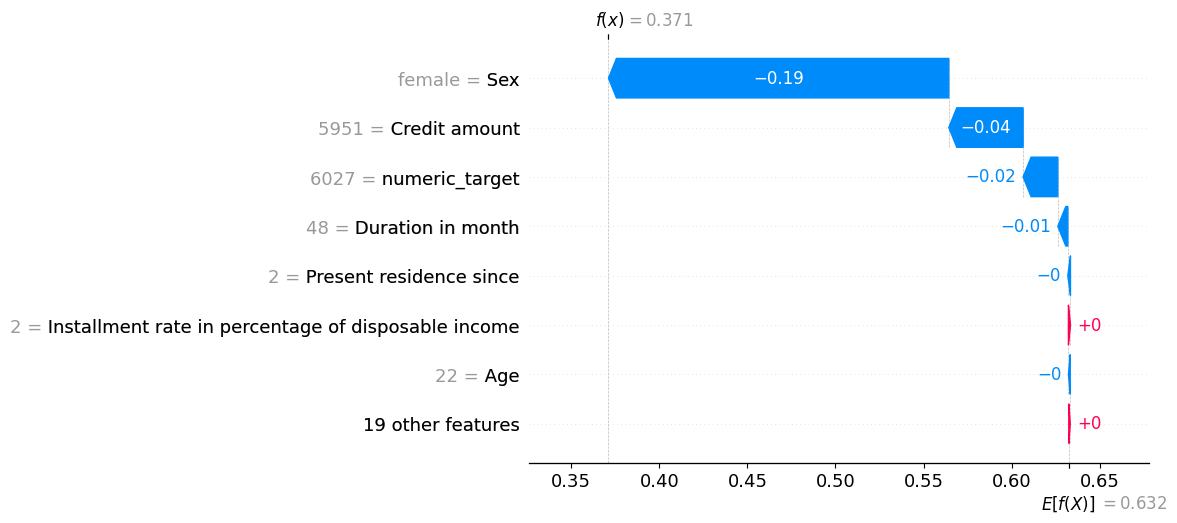

In [400]:
mean_shapper(df, model, 'Sex')

'Среднее значение таргета по классу male = 0.7159420289855073\nСреднее значение таргета по классу female = 0.3935483870967742\n'

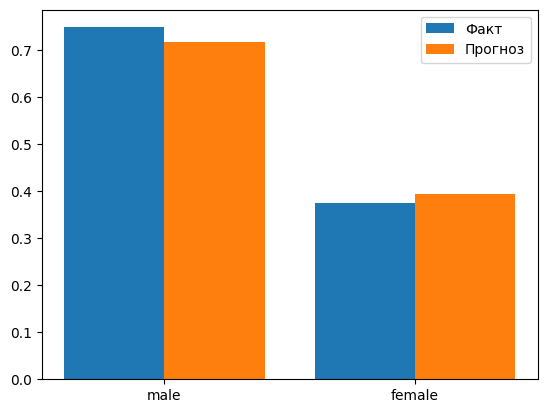

In [17]:
mean_target(df, 'Sex', 'target', 'cat_target')